See https://www.mql5.com/en/articles/9138

In [ ]:
!python3.9 -m pip install --upgrade pip
%pip install --upgrade catboost sklearn

Iteration: 0, R^2: 0.6884683728248484
Iteration: 1, R^2: 0.8084034789927547
Iteration: 2, R^2: 0.8568416631950664
Iteration: 3, R^2: 0.8947475312575383
Iteration: 4, R^2: 0.8937387403466728
Iteration: 5, R^2: 0.8740253545837738
Iteration: 6, R^2: 0.9239778494436188
Iteration: 7, R^2: 0.8995852448958686
Iteration: 8, R^2: 0.9262546217192215
Iteration: 9, R^2: 0.896460771297135
Iteration: 10, R^2: 0.8883964554730057
Iteration: 11, R^2: 0.946038990140996
Iteration: 12, R^2: 0.9608995261733444
Iteration: 13, R^2: 0.9493413910769457
Iteration: 14, R^2: 0.9517170873778855
Iteration: 15, R^2: 0.9443394070897044
Iteration: 16, R^2: 0.9572844477553593
Iteration: 17, R^2: 0.9532834708603127
Iteration: 18, R^2: 0.9548494532837222
Iteration: 19, R^2: 0.9543012498388577
Iteration: 20, R^2: 0.9405911128899989
Iteration: 21, R^2: 0.9618254291982448
Iteration: 22, R^2: 0.9398572083676434
Iteration: 23, R^2: 0.9310334844537049
Iteration: 24, R^2: 0.971483769840834


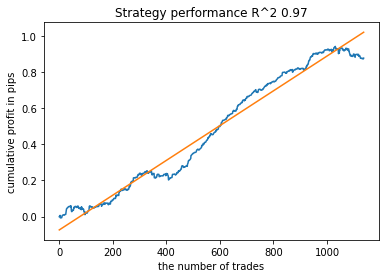

The file cat_model.mqh has been written to disc


In [4]:
from cmath import cos
import catboost
import numpy as np
import pandas as pd
from datetime import datetime
import random
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import math
# GLOBAL VARIABLES
SYMBOL = 'EURUSD'
MA_PERIODS = [i for i in range(15, 500, 15)]
MARKUP = 0.00002
START_DATE = datetime(2020, 1, 1)
TSTART_DATE = datetime(2018, 1, 1)
STOP_DATE = datetime(2021, 1, 1)
BAD_SAMPLES_BOOK = pd.DatetimeIndex([])


def get_prices() -> pd.DataFrame:
    p = pd.read_csv('EURUSDMT5.csv', delim_whitespace=True)
    pFixed = pd.DataFrame(columns=['time', 'close'])
    pFixed['time'] = p['<DATE>'] + ' ' + p['<TIME>']
    pFixed['time'] = pd.to_datetime(pFixed['time'], infer_datetime_format=True)
    pFixed['close'] = p['<CLOSE>']
    pFixed.set_index('time', inplace=True)
    pFixed.index = pd.to_datetime(pFixed.index, unit='s')
    pFixed = pFixed.dropna()
    pFixedC = pFixed.copy()

    count = 0
    for i in MA_PERIODS:
        pFixed[str(count)] = pFixedC - pFixedC.rolling(i).mean()
        count += 1
    return pFixed.dropna()

def labelling_relabeling(dataset, min=15, max=35, relabeling=False):
    labels = []
    for i in range(dataset.shape[0]-max):
        rand = random.randint(min, max)
        curr_pr = dataset['close'][i]
        future_pr = dataset['close'][i + rand]

        if relabeling:
            m_labels  = dataset['meta_labels'][i:rand+1].values
        
        if relabeling and 0.0 in m_labels:
            labels.append(2.0)
        else:
            if future_pr + MARKUP < curr_pr:
                labels.append(1.0)
            elif future_pr - MARKUP > curr_pr:
                labels.append(0.0)
            else:
                labels.append(2.0)
        
    dataset = dataset.iloc[:len(labels)].copy()
    dataset['labels'] = labels
    dataset = dataset.dropna()
    dataset = dataset.drop(
        dataset[dataset.labels == 2].index)

    return dataset

def tester(dataset: pd.DataFrame, markup=0.0, use_meta=False, plot=False):
    last_deal = int(2)
    last_price = 0.0
    report = [0.0]
    meta_labels = dataset['labels'].copy()

    for i in range(dataset.shape[0]):
        pred = dataset['labels'][i]
        meta_labels[i] = np.nan
        if use_meta:
            pred_meta = dataset['meta_labels'][i] # 1 = allow trades

        if last_deal == 2 and ((use_meta and pred_meta==1) or not use_meta):
            last_price = dataset['close'][i]
            last_deal = 0 if pred <= 0.5 else 1
            continue

        if last_deal == 0 and pred > 0.5 and ((use_meta and pred_meta==1) or not use_meta):
            last_deal = 2
            report.append(report[-1] - markup +
                          (dataset['close'][i] - last_price))
            if report[-1] > report[-2]:
                meta_labels[i] = 1
            else:
                meta_labels[i] = 0
            continue

        if last_deal == 1 and pred < 0.5 and ((use_meta and pred_meta==1) or not use_meta):
            last_deal = 2
            report.append(report[-1] - markup +
                          (last_price - dataset['close'][i]))
            if report[-1] > report[-2]:
                meta_labels[i] = 1
            else:
                meta_labels[i] = 0

    y = np.array(report).reshape(-1, 1)
    X = np.arange(len(report)).reshape(-1, 1)
    lr = LinearRegression()
    lr.fit(X, y)

    l = lr.coef_
    if l >= 0:
        l = 1
    else:
        l = -1

    if(plot):
        plt.plot(report)
        plt.plot(lr.predict(X))
        plt.title("Strategy performance R^2 " + str(format(lr.score(X, y) * l,".2f")))
        plt.xlabel("the number of trades")
        plt.ylabel("cumulative profit in pips")
        plt.show()

    return lr.score(X, y) * l, meta_labels.fillna(method='backfill')

def brute_force(dataset, bad_samples_fraction=0.5):
    # features for model\meta models. We learn main model only on filtered labels 
    X = dataset[dataset['meta_labels']==1]
    X = dataset[dataset.columns[:-2]]
    X = X[X.index >= START_DATE]
    X = X[X.index <= STOP_DATE]

    X_meta = dataset[dataset.columns[:-2]]
    X_meta = X_meta[X_meta.index >= TSTART_DATE]
    X_meta = X_meta[X_meta.index <= STOP_DATE]

    # labels for model\meta models
    y = dataset[dataset['meta_labels']==1]
    y = dataset[dataset.columns[-2]]
    y = y[y.index >= START_DATE]
    y = y[y.index <= STOP_DATE]

    y_meta = dataset[dataset.columns[-1]]
    y_meta = y_meta[y_meta.index >= TSTART_DATE]
    y_meta = y_meta[y_meta.index <= STOP_DATE]

    # train\test split
    train_X, test_X, train_y, test_y = train_test_split(
        X, y, train_size=0.5, test_size=0.5, shuffle=True)

    # learn main model with train and validation subsets
    model = CatBoostClassifier(iterations=1000,
                               depth=6,
                               learning_rate=0.1,
                               custom_loss=['Accuracy'],
                               eval_metric='Accuracy',
                               verbose=False,
                               use_best_model=True,
                               task_type='CPU')

    model.fit(train_X, train_y, eval_set=(test_X, test_y),
              early_stopping_rounds=50, plot=False)

    # train\test split
    train_X, test_X, train_y, test_y = train_test_split(
        X_meta, y_meta, train_size=0.5, test_size=0.5, shuffle=True)

    # learn meta model with train and validation subsets
    meta_model = CatBoostClassifier(iterations=1000,
                                    depth=6,
                                    learning_rate=0.1,
                                    custom_loss=['Accuracy'],
                                    eval_metric='Accuracy',
                                    verbose=False,
                                    use_best_model=True,
                                    task_type='CPU')

    meta_model.fit(train_X, train_y, eval_set=(test_X, test_y),
              early_stopping_rounds=50, plot=False)

    # predict on new data (validation plus learning)
    pr_tst = get_prices()
    X = pr_tst[pr_tst.columns[1:]]
    X.columns = [''] * len(X.columns)
    X_meta = X.copy()

    # predict the learned models (base and meta)
    p = model.predict_proba(X)
    p_meta = meta_model.predict_proba(X_meta)

    p2 = [x[0] < 0.5 for x in p]
    p2_meta = [x[0] < 0.5 for x in p_meta]
    pr2 = pr_tst.iloc[:len(p2)].copy()
    pr2['labels'] = p2
    pr2['meta_labels'] = p2_meta
    pr2['labels'] = pr2['labels'].astype(float)
    pr2['meta_labels'] = pr2['meta_labels'].astype(float)
    full_pr = pr2.copy()
    pr2 = pr2[pr2.index >= TSTART_DATE]
    pr2 = pr2[pr2.index <= STOP_DATE]

    # add bad samples of this iteratin (bad meta labels)
    global BAD_SAMPLES_BOOK
    BAD_SAMPLES_BOOK = BAD_SAMPLES_BOOK.append(pr2[pr2['meta_labels']==0.0].index)
    
    # test models and resample meta labels
    R2, meta_labels = tester(pr2, MARKUP, use_meta=True, plot=False)
    pr2['meta_labels'] = meta_labels

    # resample labels based on meta labels
    pr2 = labelling_relabeling(pr2, relabeling=True)
    pr2['labels'] = pr2['labels'].astype(float)
    pr2['meta_labels'] = pr2['meta_labels'].astype(float)

    # mark bad labels from bad_samples_book
    if BAD_SAMPLES_BOOK.value_counts().max() > 1:
        to_mark = BAD_SAMPLES_BOOK.value_counts()
        mean = to_mark.mean()
        marked_idx = to_mark[to_mark > mean*bad_samples_fraction].index
        pr2.loc[pr2.index.isin(marked_idx), 'meta_labels'] = 0.0
    else:
        pr2.loc[pr2.index.isin(BAD_SAMPLES_BOOK), 'meta_labels'] = 0.0

    R2, _ = tester(full_pr, MARKUP, use_meta=True, plot=False)

    return [R2, model, meta_model, pr2]

def test_model(result: list):
    pr_tst = get_prices()
    X = pr_tst[pr_tst.columns[1:]]
    X.columns = [''] * len(X.columns)
    X_meta = X.copy()

    # test the learned model
    p = result[1].predict_proba(X)
    p_meta = result[2].predict_proba(X_meta)
    p2 = [x[0] < 0.5 for x in p]
    p2_meta = [x[0] < 0.5 for x in p_meta]
    pr2 = pr_tst.iloc[:len(p2)].copy()
    pr2['labels'] = p2
    pr2['labels'] = pr2['labels'].astype(float)
    pr2['meta_labels'] = p2_meta  
    pr2['meta_labels'] = pr2['meta_labels'].astype(float)
    R2, meta_labels = tester(pr2, MARKUP, use_meta=True, plot=True)

def export_model_to_MQL_code(model, model_number):
    model[1].save_model('catmodel.h',
                     format="cpp",
                     export_parameters=None,
                     pool=None)
    model[2].save_model('meta_catmodel.h',
                     format="cpp",
                     export_parameters=None,
                     pool=None)
    # add variables
    code = '#include <Math\Stat\Math.mqh>'
    code += '\n'
    code += 'int MAs' + model_number + '[' + str(len(MA_PERIODS)) + \
        '] = {' + ','.join(map(str, MA_PERIODS)) + '};'
    code += '\n'

    # get features
    code += 'void fill_arays' + model_number + '( double &features[]) {\n'
    code += '   double pr[], ret[];\n'
    code += '   ArrayResize(ret, 1);\n'
    code += '   for(int i=ArraySize(MAs' + model_number + ')-1; i>=0; i--) {\n'
    code += '       CopyClose(NULL,PERIOD_CURRENT,1,MAs' + model_number + '[i],pr);\n'
    code += '       double mean = MathMean(pr);\n'
    code += '       double std = MathStandardDeviation(pr);\n'
    code += '       ret[0] = pr[MAs' + model_number + '[i]-1] - mean;\n'
    code += '       ArrayInsert(features, ret, ArraySize(features), 0, WHOLE_ARRAY); }\n'
    code += '   ArraySetAsSeries(features, true);\n'
    code += '}\n\n'

    # add CatBosst base model
    code += 'double catboost_model' + model_number + '(const double &features[]) { \n'
    code += '    '
    with open('catmodel.h', 'r') as file:
        data = file.read()
        code += data[data.find("unsigned int TreeDepth")
                               :data.find("double Scale = 1;")]
    code += '\n\n'
    code += 'return ' + \
        'ApplyCatboostModel' + model_number + '(features, TreeDepth, TreeSplits , BorderCounts, Borders, LeafValues); } \n\n'

    # add CatBosst meta model
    code += 'double catboost_meta_model' + model_number + '(const double &features[]) { \n'
    code += '    '
    with open('meta_catmodel.h', 'r') as file:
        data = file.read()
        code += data[data.find("unsigned int TreeDepth")
                               :data.find("double Scale = 1;")]
    code += '\n\n'
    code += 'return ' + \
        'ApplyCatboostModel' + model_number + '(features, TreeDepth, TreeSplits , BorderCounts, Borders, LeafValues); } \n\n'

    code += 'double ApplyCatboostModel' + model_number + '(const double &features[],uint &TreeDepth_[],uint &TreeSplits_[],uint &BorderCounts_[],float &Borders_[],double &LeafValues_[]) {\n\
    uint FloatFeatureCount=ArrayRange(BorderCounts_,0);\n\
    uint BinaryFeatureCount=ArrayRange(Borders_,0);\n\
    uint TreeCount=ArrayRange(TreeDepth_,0);\n\
    bool     binaryFeatures[];\n\
    ArrayResize(binaryFeatures,BinaryFeatureCount);\n\
    uint binFeatureIndex=0;\n\
    for(uint i=0; i<FloatFeatureCount; i++) {\n\
       for(uint j=0; j<BorderCounts_[i]; j++) {\n\
          binaryFeatures[binFeatureIndex]=features[i]>Borders_[binFeatureIndex];\n\
          binFeatureIndex++;\n\
       }\n\
    }\n\
    double result=0.0;\n\
    uint treeSplitsPtr=0;\n\
    uint leafValuesForCurrentTreePtr=0;\n\
    for(uint treeId=0; treeId<TreeCount; treeId++) {\n\
       uint currentTreeDepth=TreeDepth_[treeId];\n\
       uint index=0;\n\
       for(uint depth=0; depth<currentTreeDepth; depth++) {\n\
          index|=(binaryFeatures[TreeSplits_[treeSplitsPtr+depth]]<<depth);\n\
       }\n\
       result+=LeafValues_[leafValuesForCurrentTreePtr+index];\n\
       treeSplitsPtr+=currentTreeDepth;\n\
       leafValuesForCurrentTreePtr+=(1<<currentTreeDepth);\n\
    }\n\
    return 1.0/(1.0+MathPow(M_E,-result));\n\
    }\n\n'



    # file = open('/Users/dmitrievsky/Desktop/py files/mql models/' + str(SYMBOL) + 'cat_model_META_NEW' + model_number + '.mqh', "w")
    file = open(str(SYMBOL) + 'cat_model_META_NEW' + model_number + '.mqh', "w")
    file.write(code)

    file.close()
    print('The file ' + 'cat_model' + '.mqh ' + 'has been written to disc')


# make dataset
pr = get_prices()
pr = labelling_relabeling(pr, relabeling=False)
a, b = tester(pr, MARKUP, use_meta=False, plot=False)
pr['meta_labels'] = b
pr = pr.dropna()
pr = labelling_relabeling(pr, relabeling=True)


# iterative learning
res = []
BAD_SAMPLES_BOOK = pd.DatetimeIndex([])
for i in range(25):
    res.append(brute_force(pr[pr.columns[1:]], bad_samples_fraction=0.5))

    print('Iteration: {}, R^2: {}'.format(i, res[-1][0]))
    pr = res[-1][3] 

# test best model
res.sort()
p = test_model(res[-1])

# export best model to mql
export_model_to_MQL_code(res[-1], str(1))
